In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
magic_gamma_telescope = fetch_ucirepo(id=159)

# metadata
print(magic_gamma_telescope.metadata)

# variable information
print(magic_gamma_telescope.variables)

{'uci_id': 159, 'name': 'MAGIC Gamma Telescope', 'repository_url': 'https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope', 'data_url': 'https://archive.ics.uci.edu/static/public/159/data.csv', 'abstract': 'Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 19020, 'num_features': 10, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2004, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C52C8B', 'creators': ['R. Bock'], 'intro_paper': None, 'additional_info': {'summary': "The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamm

In [4]:
X = magic_gamma_telescope.data.features
y = magic_gamma_telescope.data.targets
cols = ["fLength", "fWidth", "fSize", "fConc","fConc1","fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.concat([X,y], axis=1)
df.columns = cols
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [5]:
print(df["class"].unique())

['g' 'h']


In [6]:
df["class"] = (df["class"]=="g").astype(int)

In [7]:
print(df["class"].unique())

[1 0]


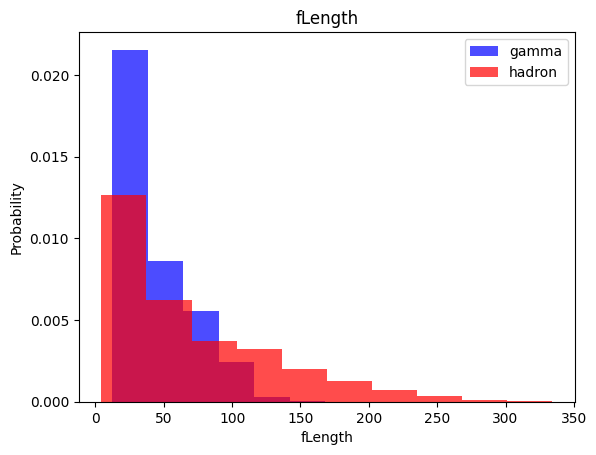

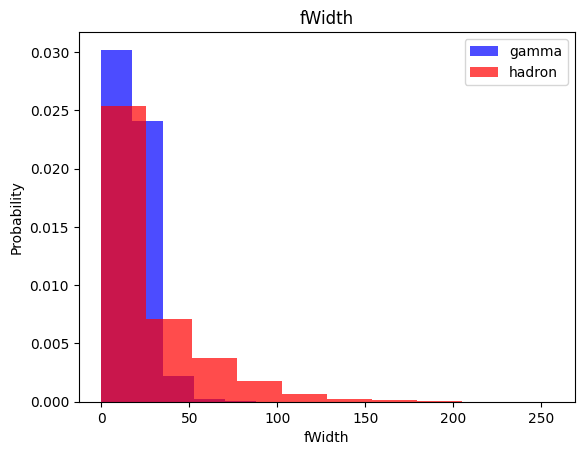

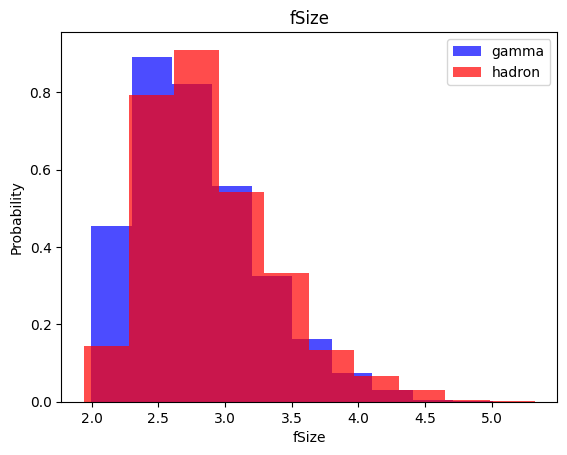

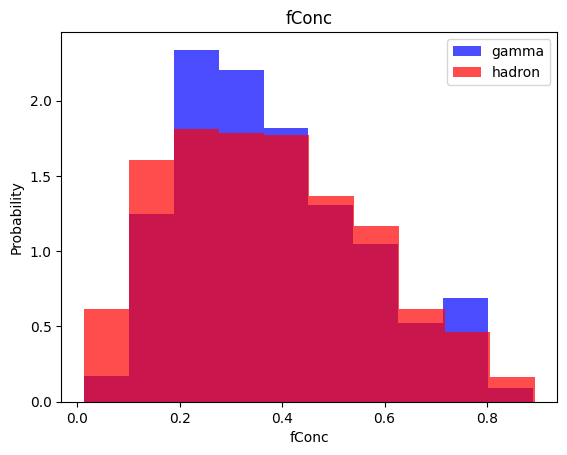

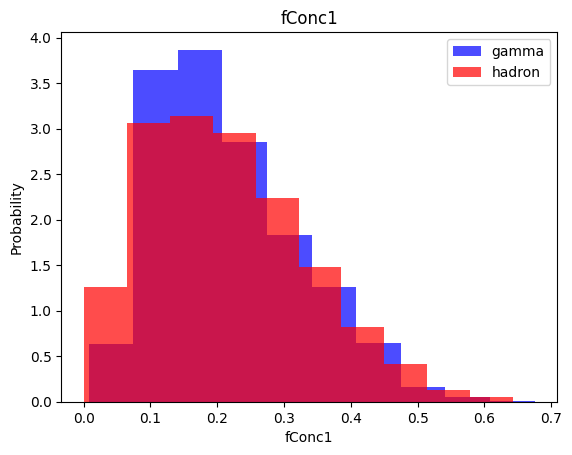

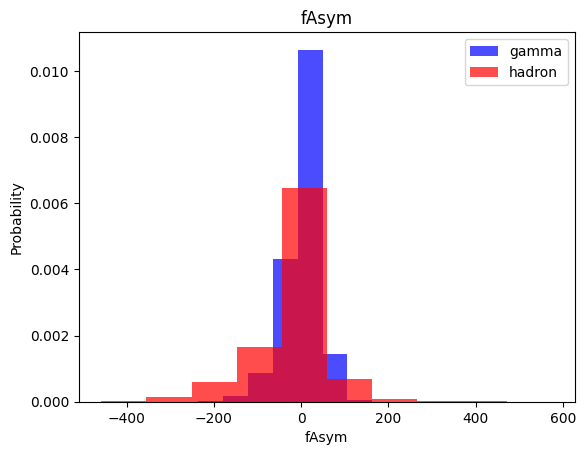

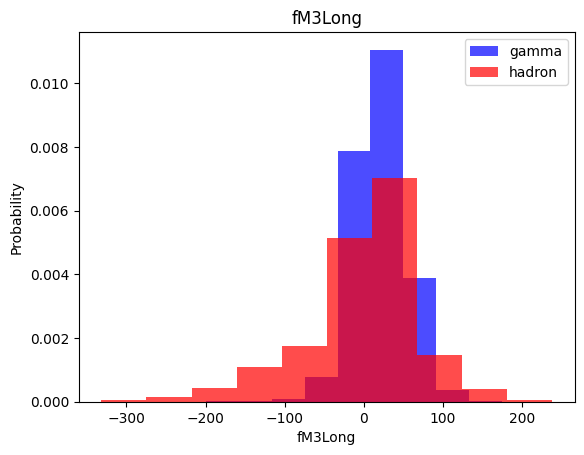

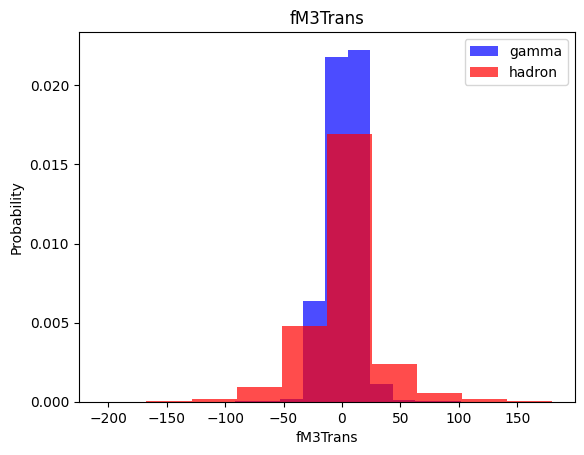

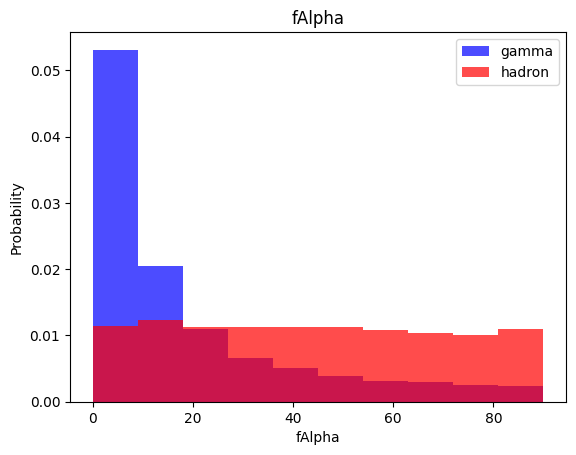

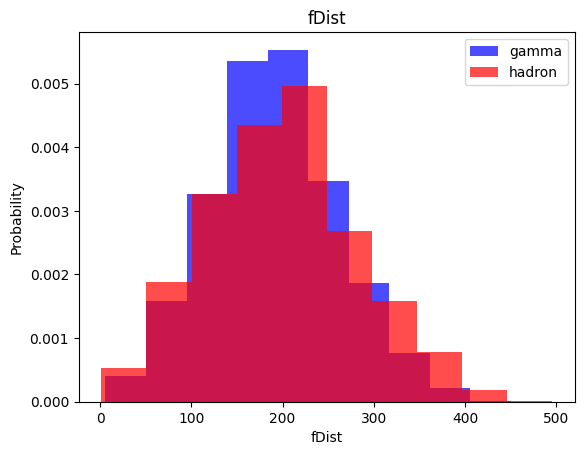

In [8]:
for label in cols[:-1]:
    plt.hist(df[df["class"]==1][label], color='blue', label='gamma', alpha=0.7, density=True)
    plt.hist(df[df["class"]==0][label], color='red', label='hadron', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

Train, Validation, Test dataset

In [9]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)) , int(0.8*len(df))])
print(f'{len(train)},{len(valid)},{len(test)}')
print(f'{len(train[train["class"]==1])}')
print(f'{len(train[train["class"]==0])}')

11412,3804,3804
7407
4005


C:\Users\Sama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Standardize features to be on a similar scale.

In [10]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    #standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    #randomly duplicating samples from the minority class to balance the classes
    if oversample:
        ros = RandomOverSampler()
        X,y = ros.fit_resample(X,y)

    data = np.hstack((X,np.reshape(y,(-1,1))))

    return data, X, y

In [11]:
train, X_train, y_train = scale_dataset(train, oversample=True)
print(len(X_train))
print(sum(y_train==1))
print(sum(y_train==0))


14814
7407
7407


In [12]:
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [14]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1319
           1       0.86      0.87      0.86      2485

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



Logistic Regression.

In [15]:
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression()
lg_model.fit(X_train,y_train)

LogisticRegression()

In [16]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1319
           1       0.85      0.82      0.84      2485

    accuracy                           0.79      3804
   macro avg       0.77      0.78      0.77      3804
weighted avg       0.79      0.79      0.79      3804



SVM

In [17]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [18]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1319
           1       0.89      0.90      0.89      2485

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



Neural Net.

In [19]:
import tensorflow as tf

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    plt.show()

TensorFlow version: 2.17.0
TensorFlow installation path: C:\Users\Sama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\__init__.py


In [20]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                    metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    return nn_model, history

nodes 16, dropout 0, lr 0.01, batch size 32


C:\Users\Sama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


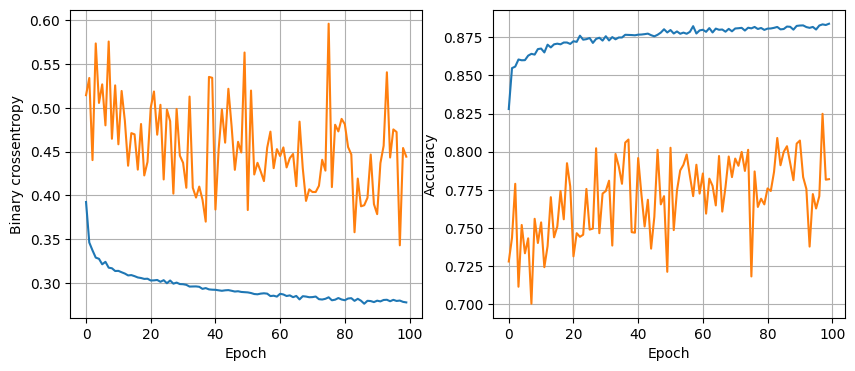

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8743 - loss: 0.3154
nodes 16, dropout 0, lr 0.01, batch size 64


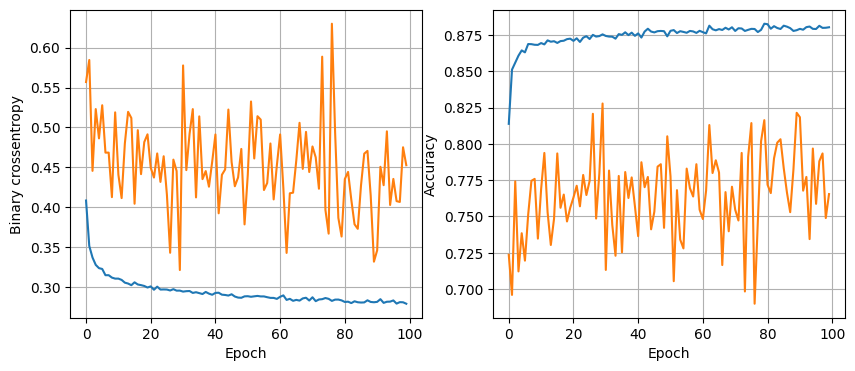

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - loss: 0.3270
nodes 16, dropout 0, lr 0.01, batch size 128


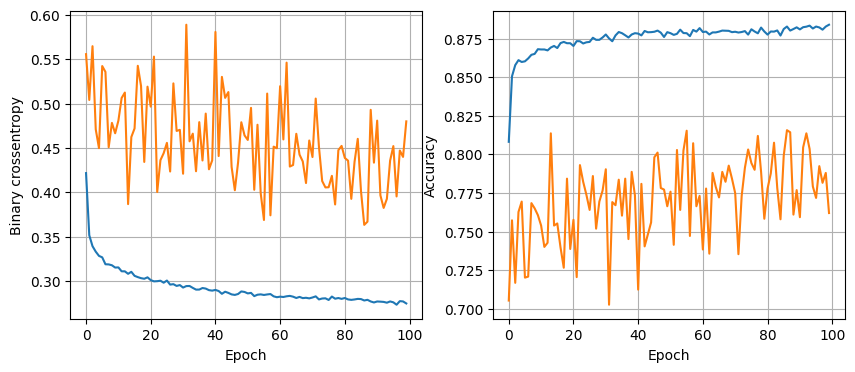

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3211
nodes 16, dropout 0, lr 0.005, batch size 32


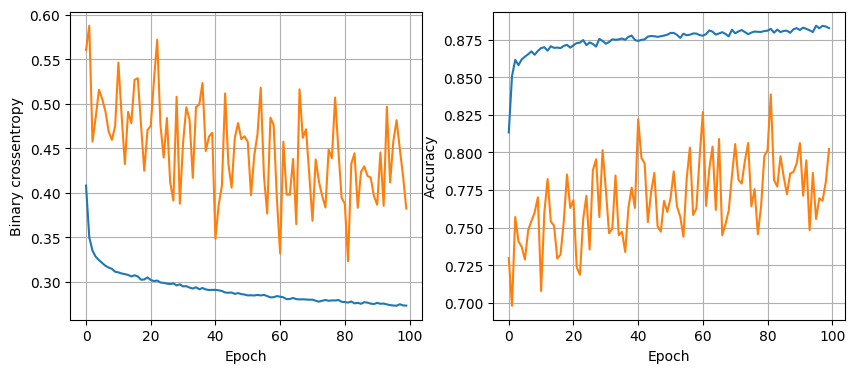

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.3380
nodes 16, dropout 0, lr 0.005, batch size 64


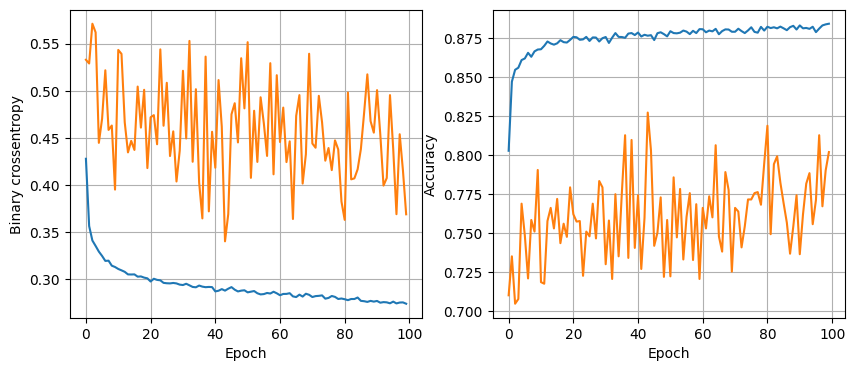

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8660 - loss: 0.3209
nodes 16, dropout 0, lr 0.005, batch size 128


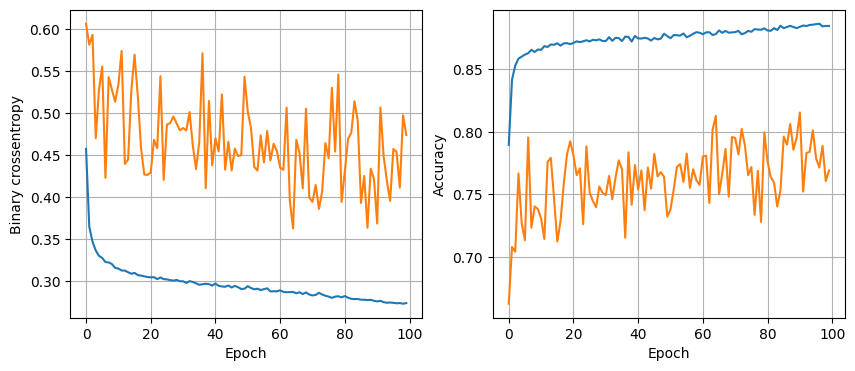

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.3111
nodes 16, dropout 0, lr 0.001, batch size 32


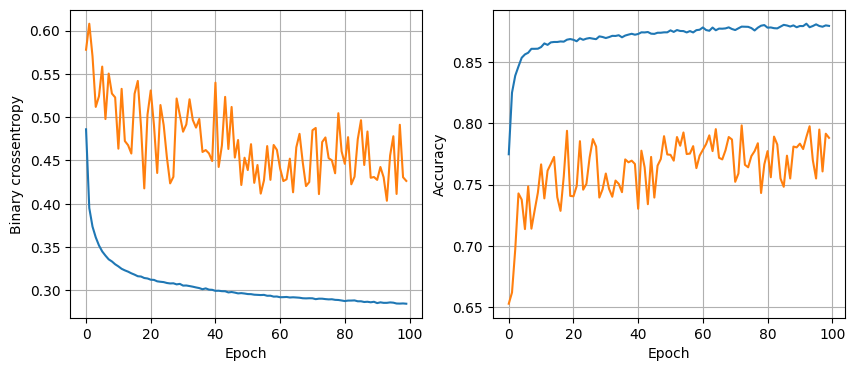

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.3176
nodes 16, dropout 0, lr 0.001, batch size 64


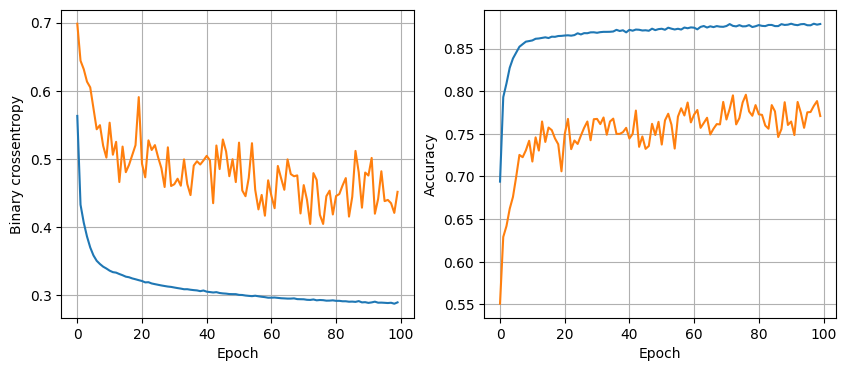

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8725 - loss: 0.3087
nodes 16, dropout 0, lr 0.001, batch size 128


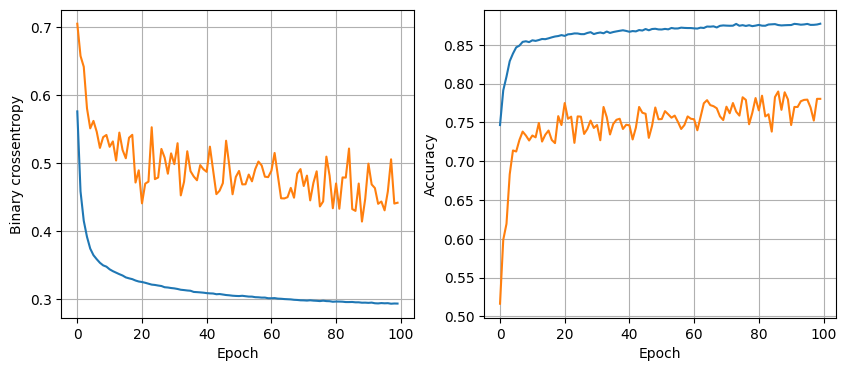

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.3176
nodes 16, dropout 0.2, lr 0.01, batch size 32


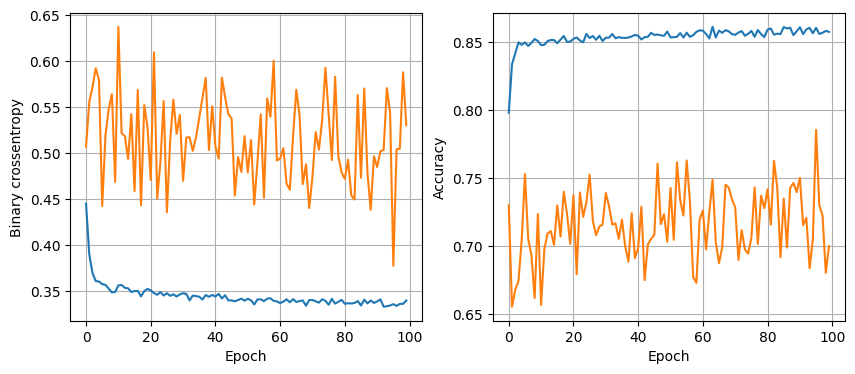

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3295
nodes 16, dropout 0.2, lr 0.01, batch size 64


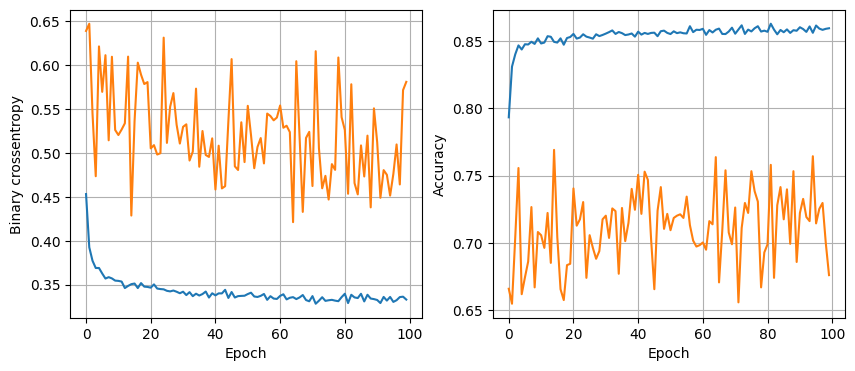

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.3315
nodes 16, dropout 0.2, lr 0.01, batch size 128


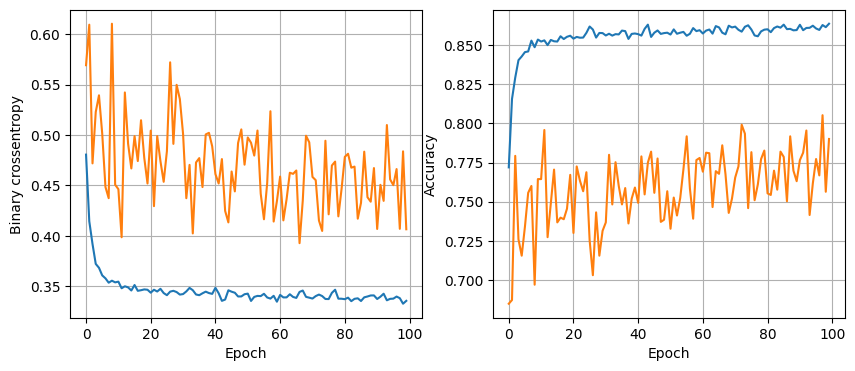

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.3317
nodes 16, dropout 0.2, lr 0.005, batch size 32


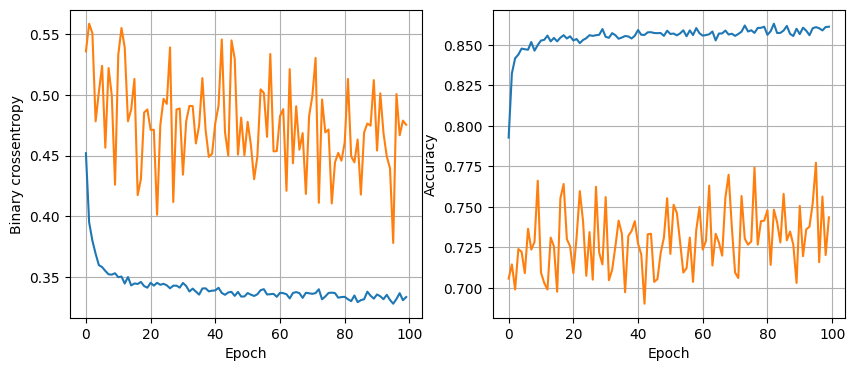

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3228
nodes 16, dropout 0.2, lr 0.005, batch size 64


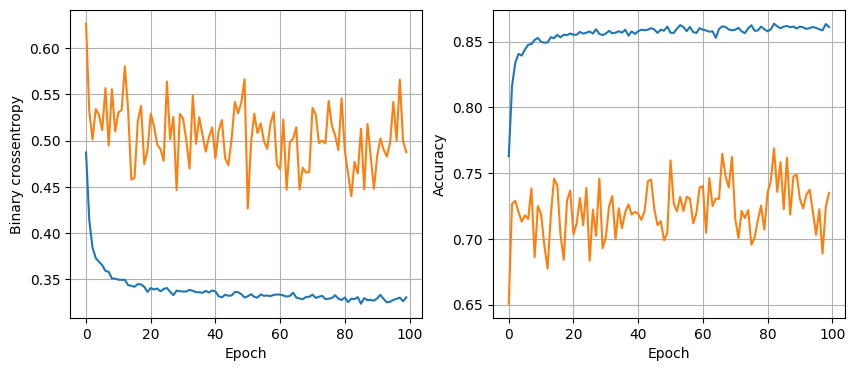

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.3203
nodes 16, dropout 0.2, lr 0.005, batch size 128


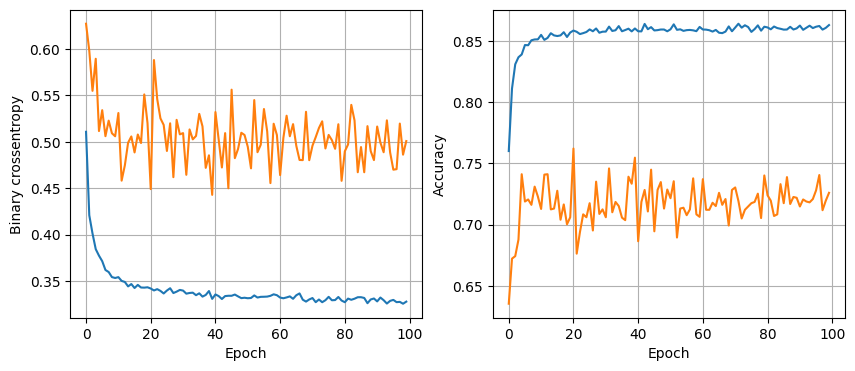

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8661 - loss: 0.3218
nodes 16, dropout 0.2, lr 0.001, batch size 32


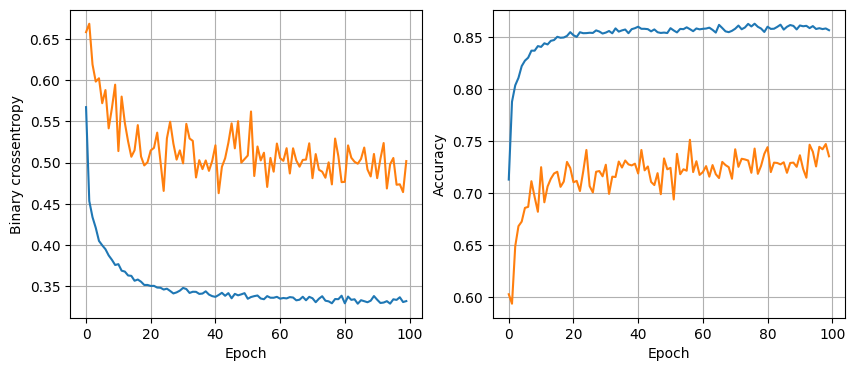

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.3288
nodes 16, dropout 0.2, lr 0.001, batch size 64


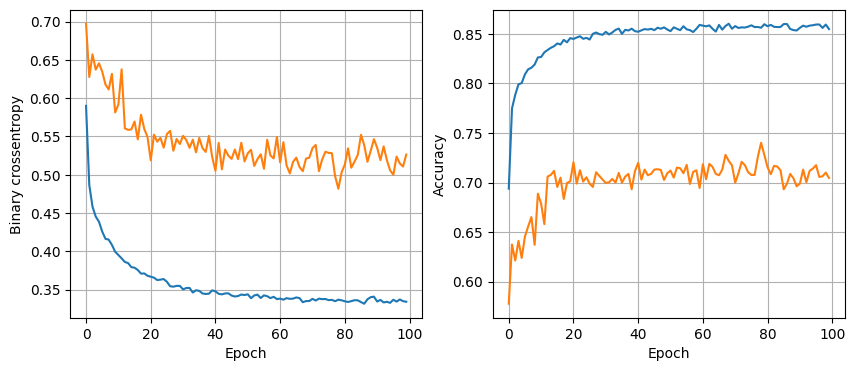

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8647 - loss: 0.3332
nodes 16, dropout 0.2, lr 0.001, batch size 128


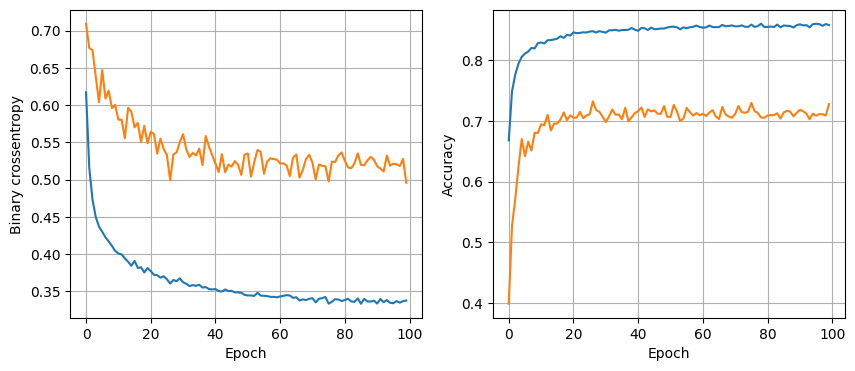

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.3259
nodes 32, dropout 0, lr 0.01, batch size 32


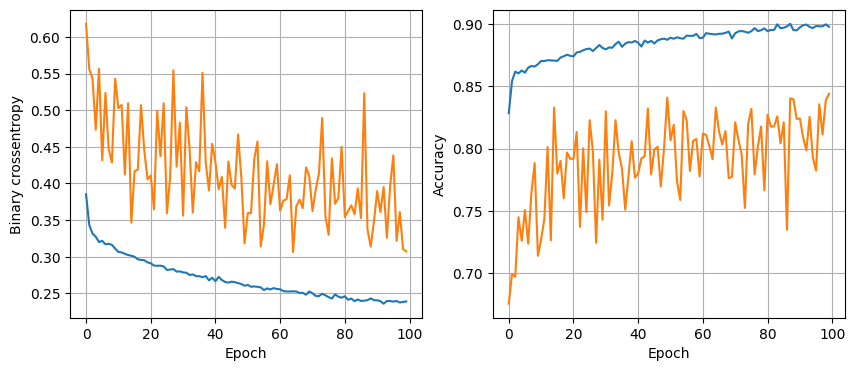

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.3757
nodes 32, dropout 0, lr 0.01, batch size 64


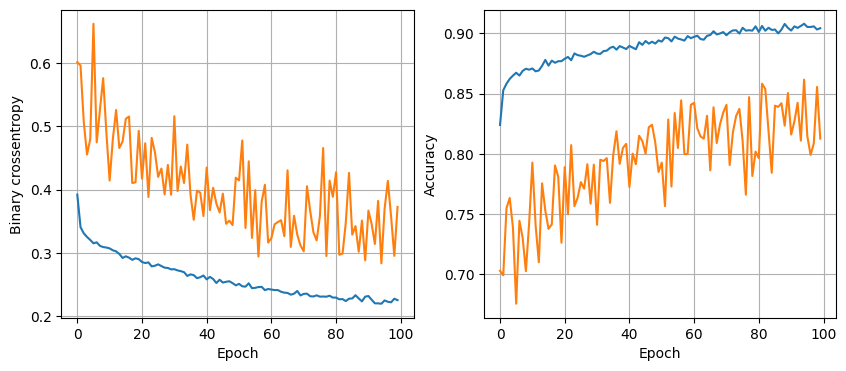

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.3964
nodes 32, dropout 0, lr 0.01, batch size 128


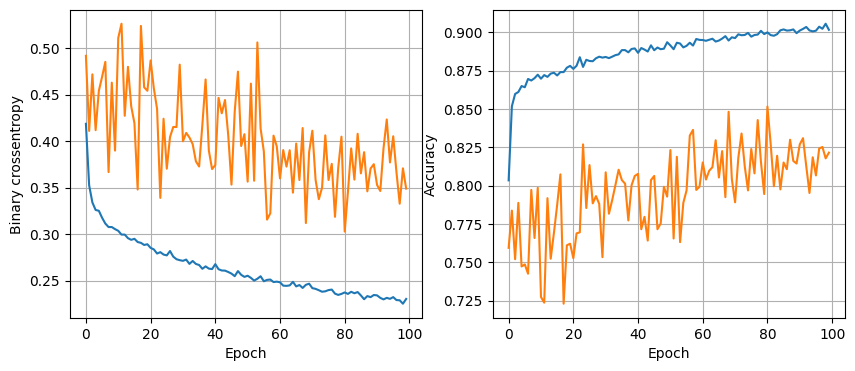

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.3551
nodes 32, dropout 0, lr 0.005, batch size 32


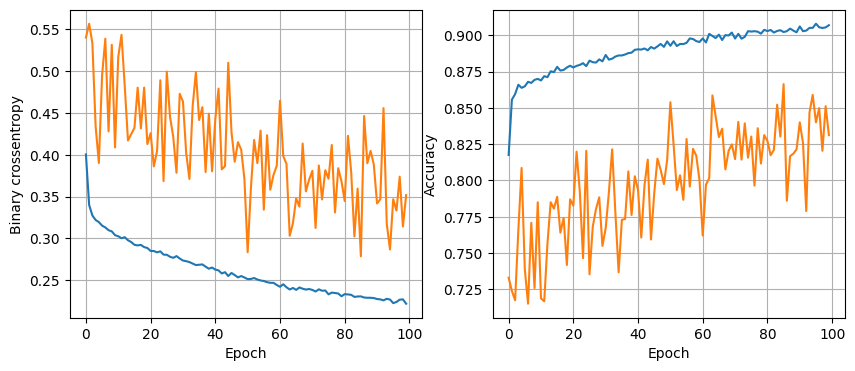

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8762 - loss: 0.3454
nodes 32, dropout 0, lr 0.005, batch size 64


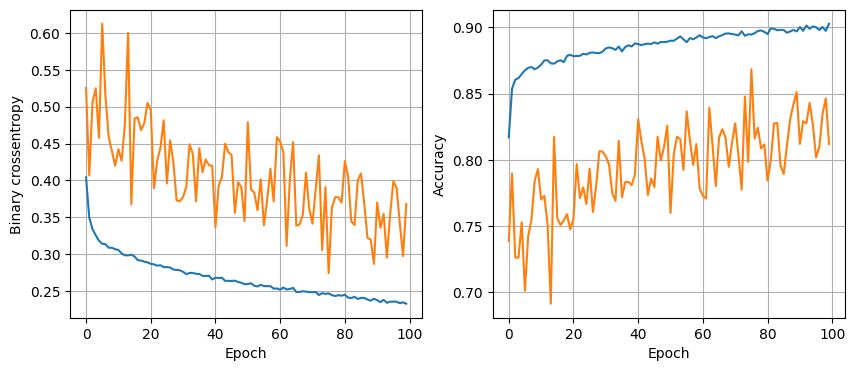

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8639 - loss: 0.3484
nodes 32, dropout 0, lr 0.005, batch size 128


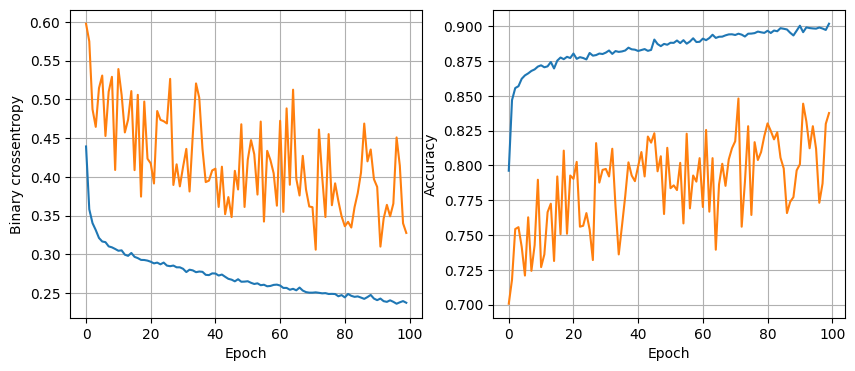

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8590 - loss: 0.3395
nodes 32, dropout 0, lr 0.001, batch size 32


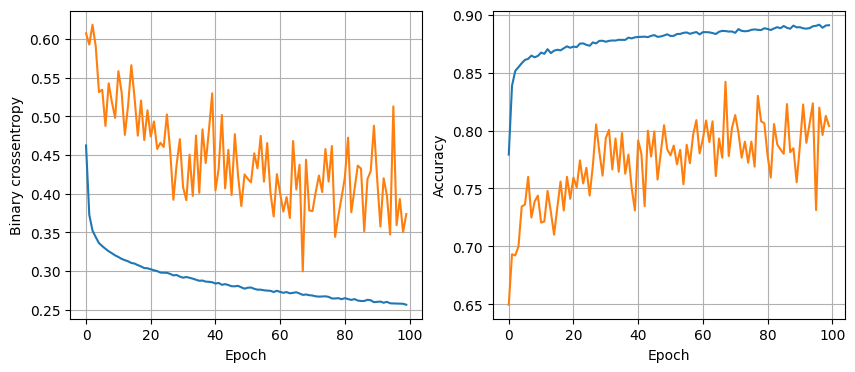

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.8686 - loss: 0.3215
nodes 32, dropout 0, lr 0.001, batch size 64


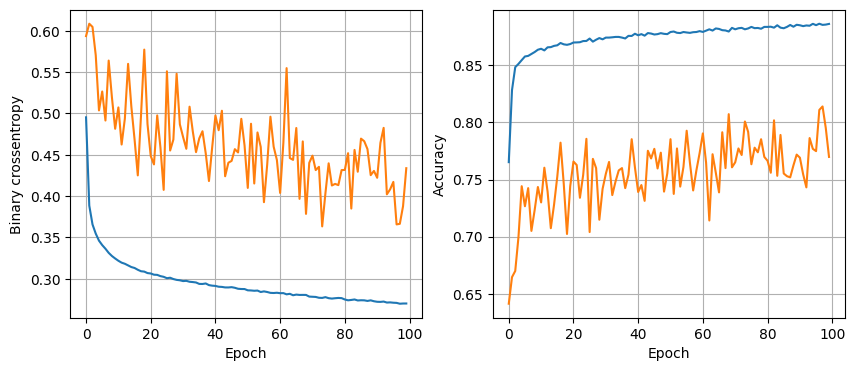

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8730 - loss: 0.3087
nodes 32, dropout 0, lr 0.001, batch size 128


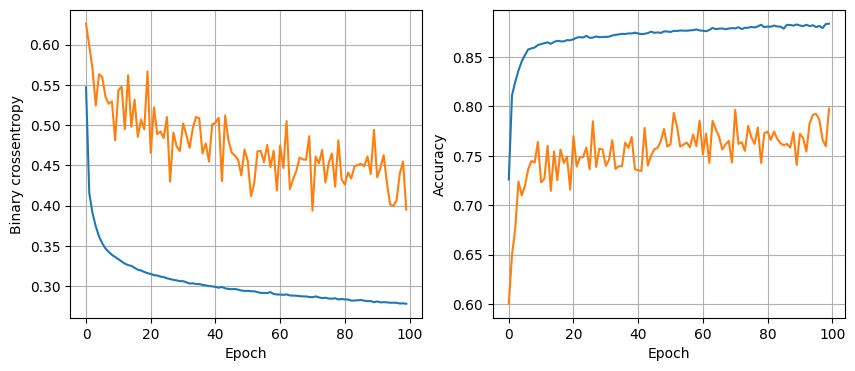

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8684 - loss: 0.3158
nodes 32, dropout 0.2, lr 0.01, batch size 32


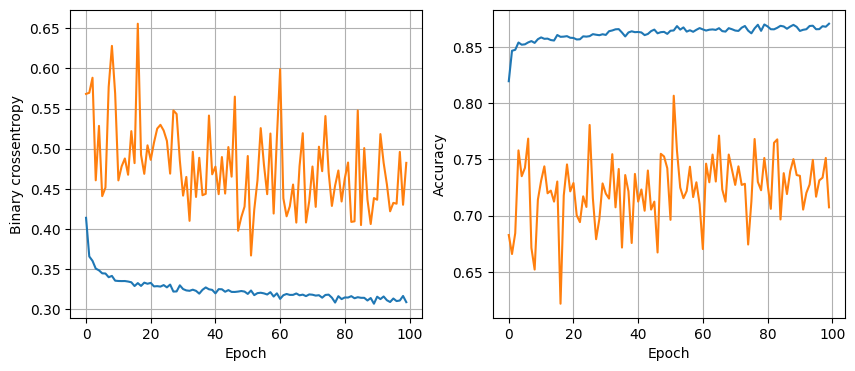

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8614 - loss: 0.3225
nodes 32, dropout 0.2, lr 0.01, batch size 64


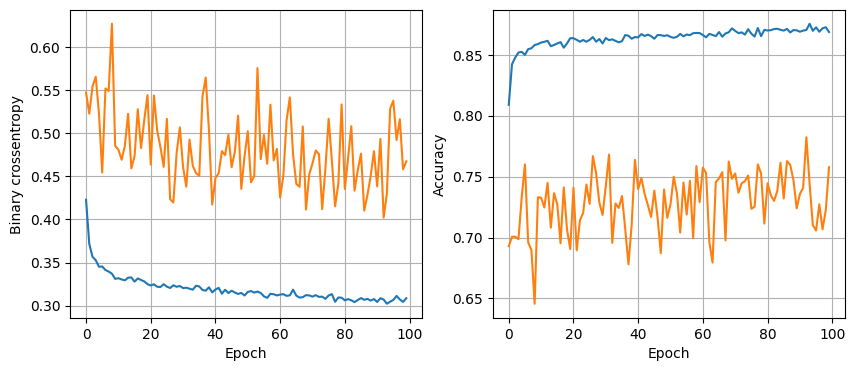

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3100
nodes 32, dropout 0.2, lr 0.01, batch size 128


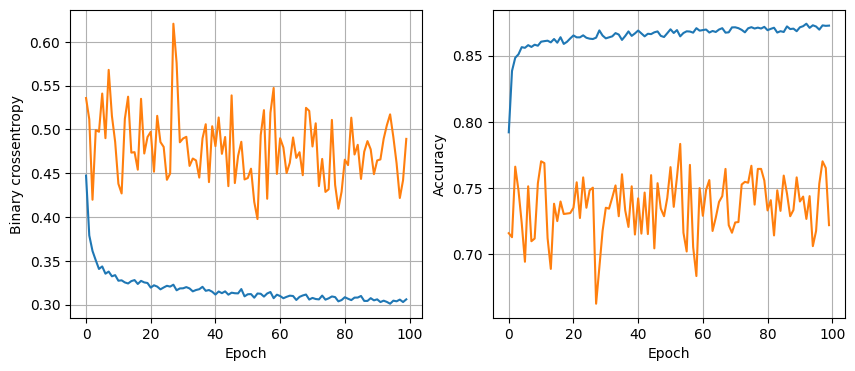

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8708 - loss: 0.3107
nodes 32, dropout 0.2, lr 0.005, batch size 32


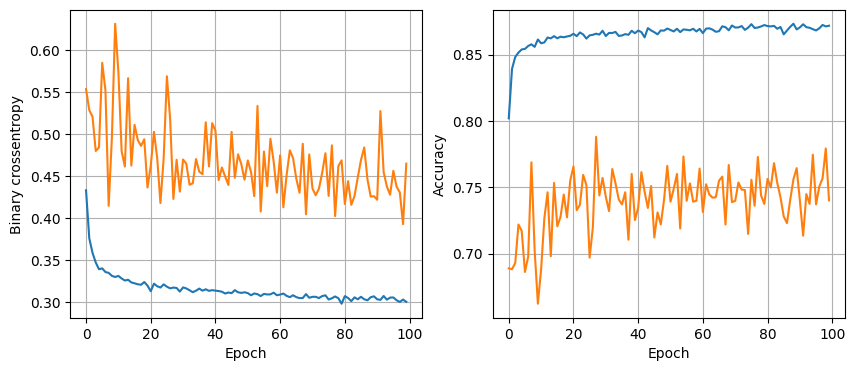

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3084
nodes 32, dropout 0.2, lr 0.005, batch size 64


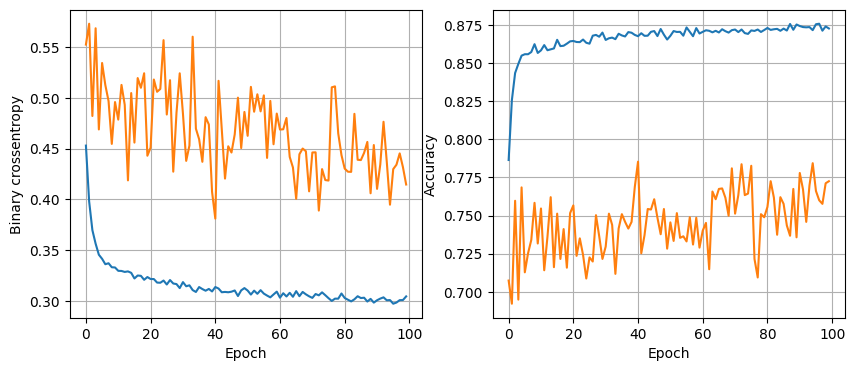

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8721 - loss: 0.3034
nodes 32, dropout 0.2, lr 0.005, batch size 128


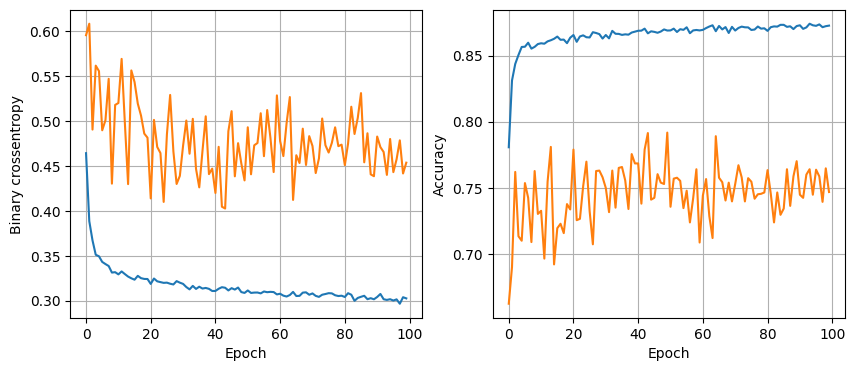

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3043
nodes 32, dropout 0.2, lr 0.001, batch size 32


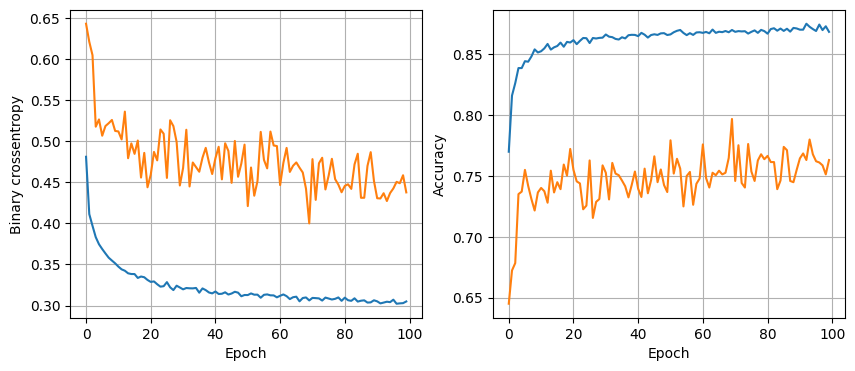

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3081
nodes 32, dropout 0.2, lr 0.001, batch size 64


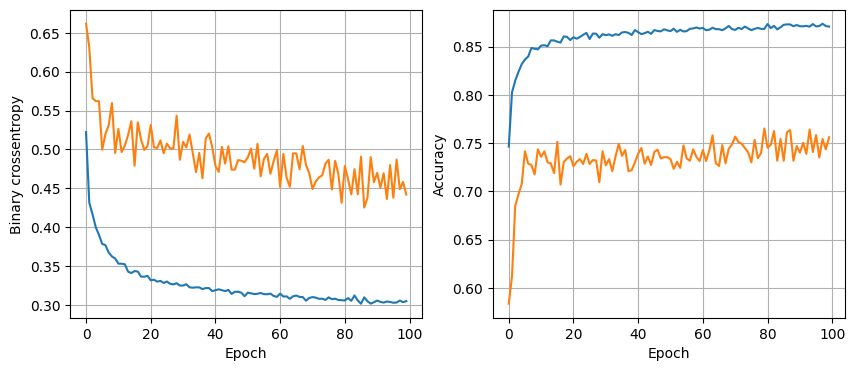

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3072
nodes 32, dropout 0.2, lr 0.001, batch size 128


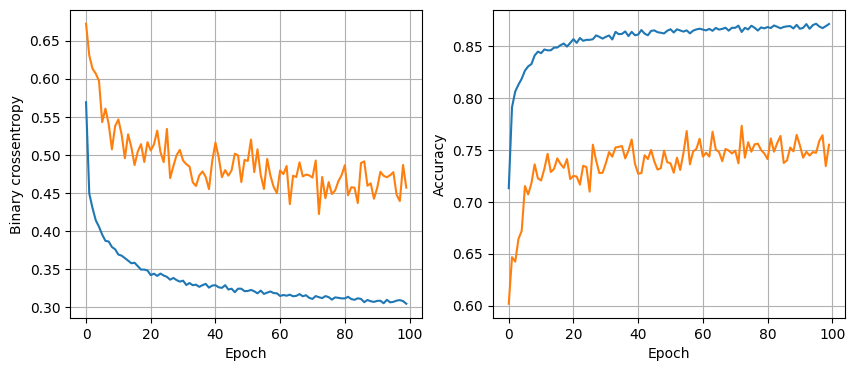

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 0.3130
nodes 64, dropout 0, lr 0.01, batch size 32


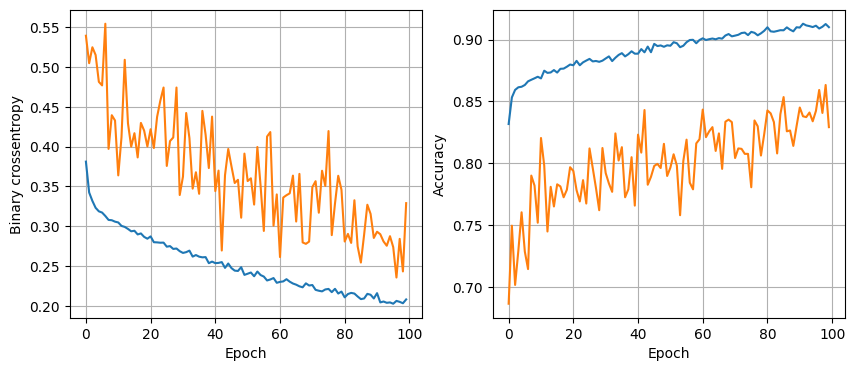

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.4390
nodes 64, dropout 0, lr 0.01, batch size 64


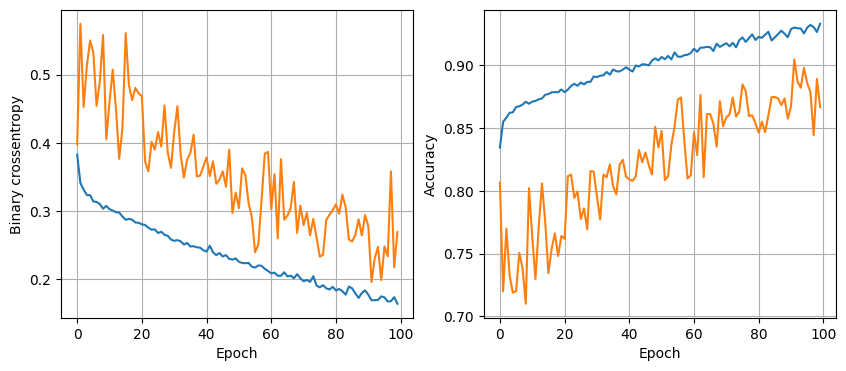

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8559 - loss: 0.4582
nodes 64, dropout 0, lr 0.01, batch size 128


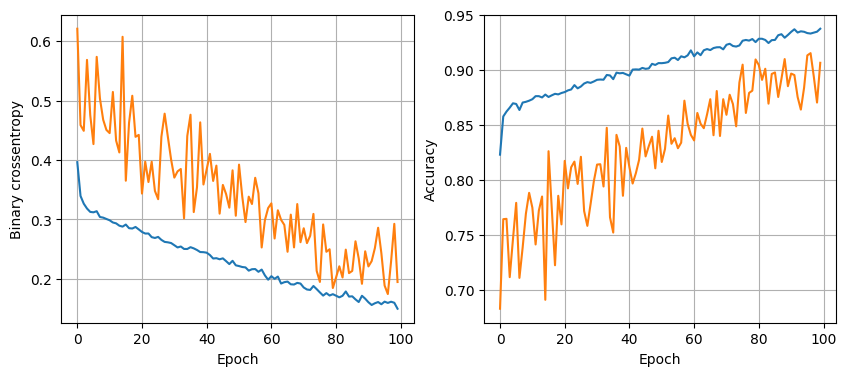

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.5121
nodes 64, dropout 0, lr 0.005, batch size 32


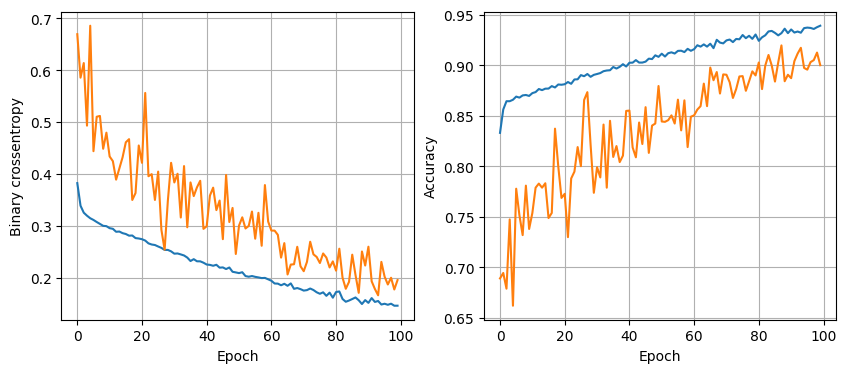

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.5825
nodes 64, dropout 0, lr 0.005, batch size 64


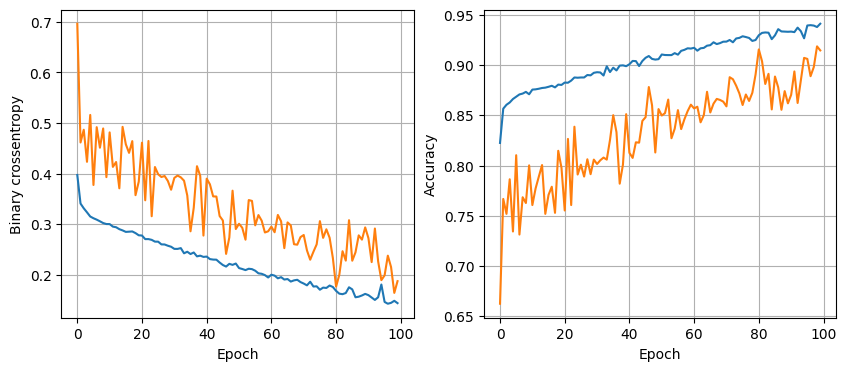

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8465 - loss: 0.5233
nodes 64, dropout 0, lr 0.005, batch size 128


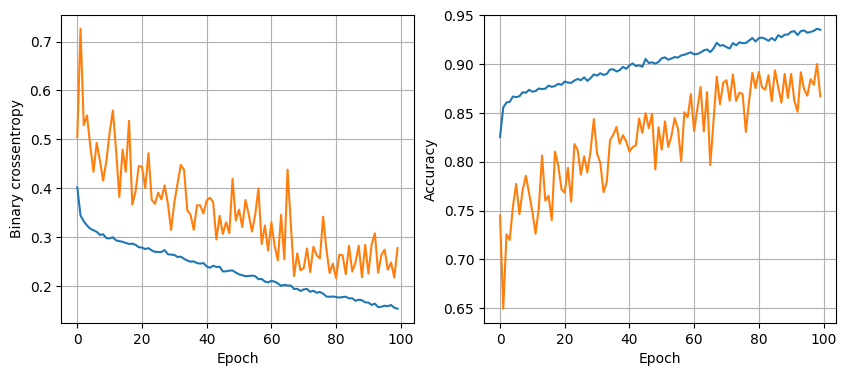

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.4815
nodes 64, dropout 0, lr 0.001, batch size 32


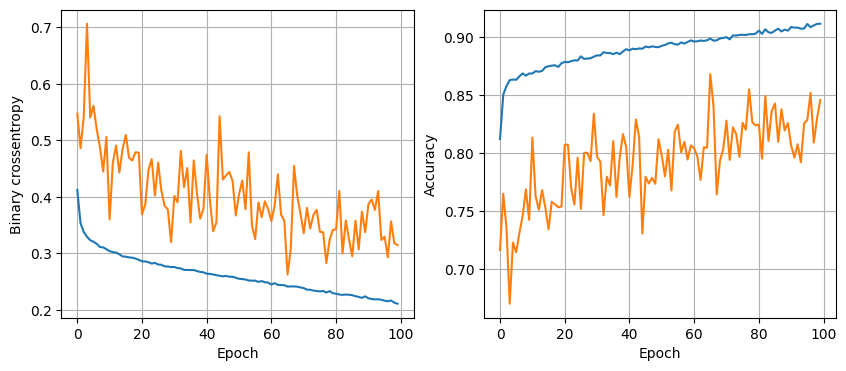

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.3489
nodes 64, dropout 0, lr 0.001, batch size 64


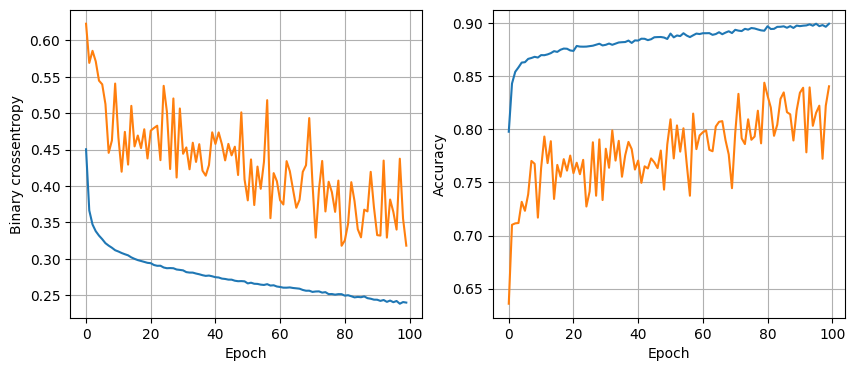

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8594 - loss: 0.3293
nodes 64, dropout 0, lr 0.001, batch size 128


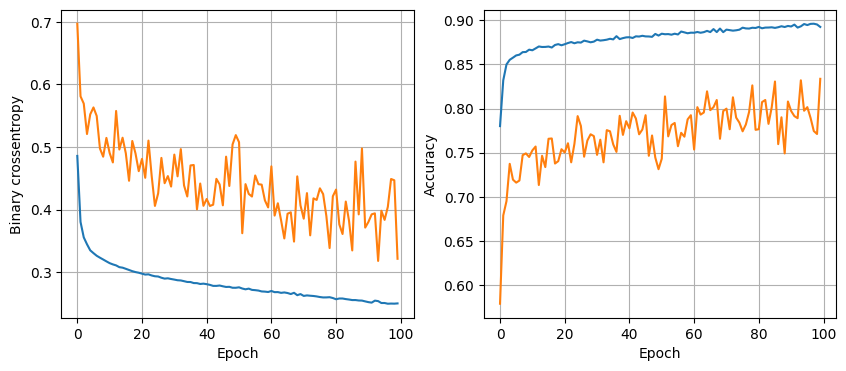

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8663 - loss: 0.3212
nodes 64, dropout 0.2, lr 0.01, batch size 32


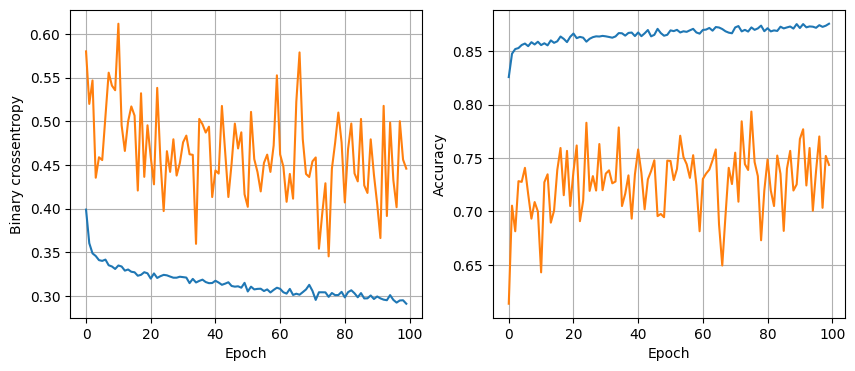

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3185
nodes 64, dropout 0.2, lr 0.01, batch size 64


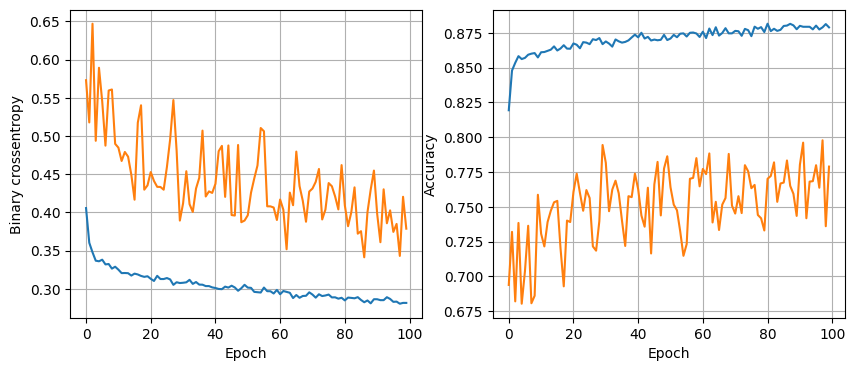

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8744 - loss: 0.3114
nodes 64, dropout 0.2, lr 0.01, batch size 128


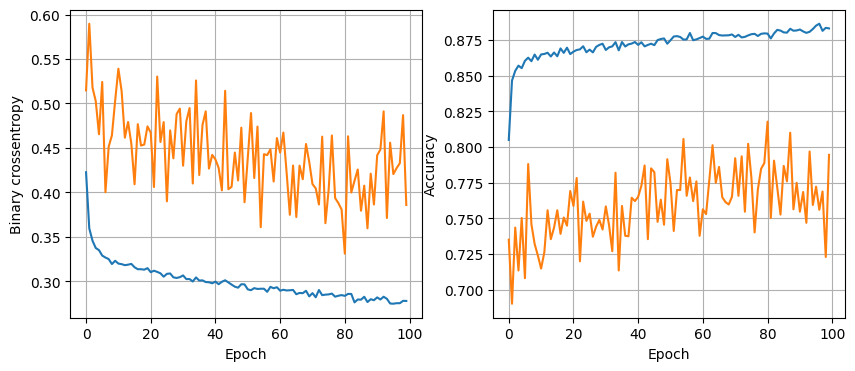

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.2982
nodes 64, dropout 0.2, lr 0.005, batch size 32


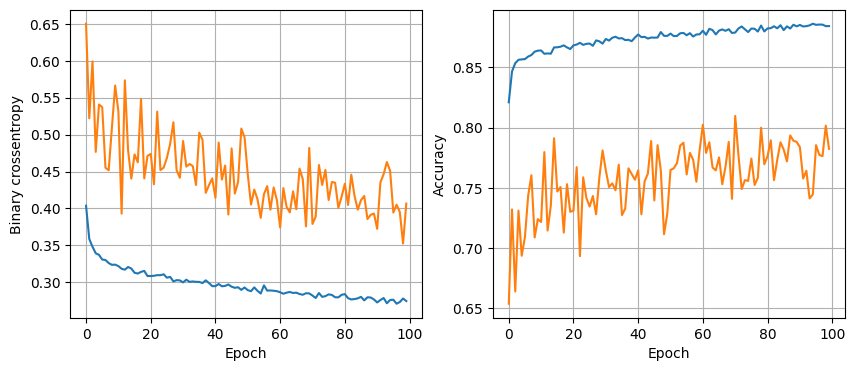

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - loss: 0.3027
nodes 64, dropout 0.2, lr 0.005, batch size 64


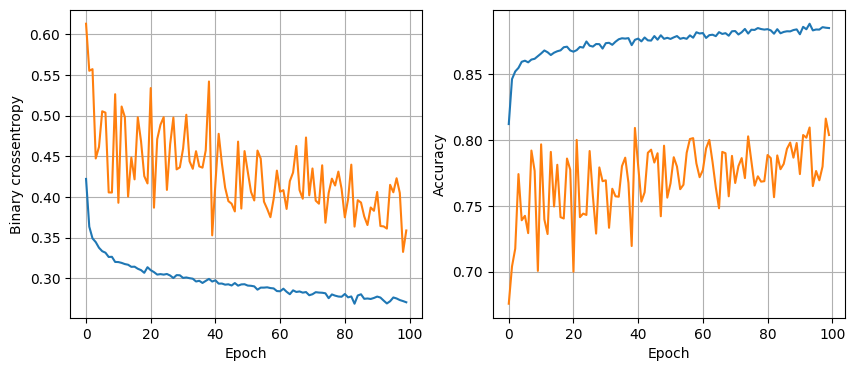

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8782 - loss: 0.2979
nodes 64, dropout 0.2, lr 0.005, batch size 128


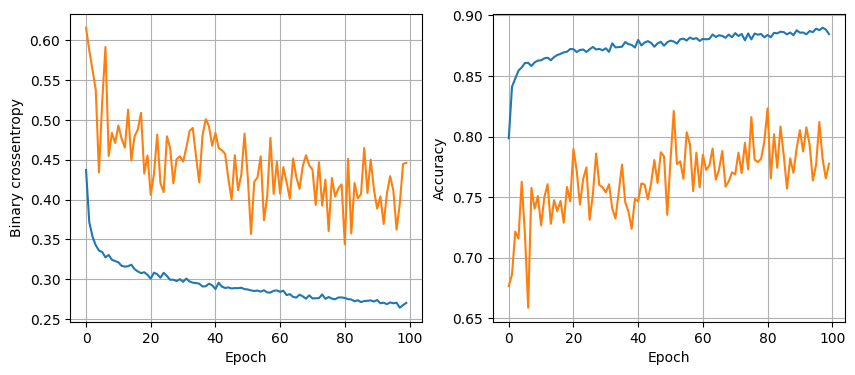

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.3075
nodes 64, dropout 0.2, lr 0.001, batch size 32


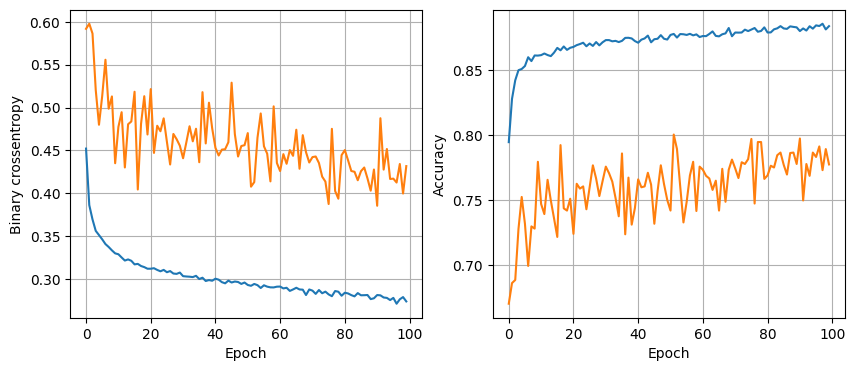

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8795 - loss: 0.2953
nodes 64, dropout 0.2, lr 0.001, batch size 64


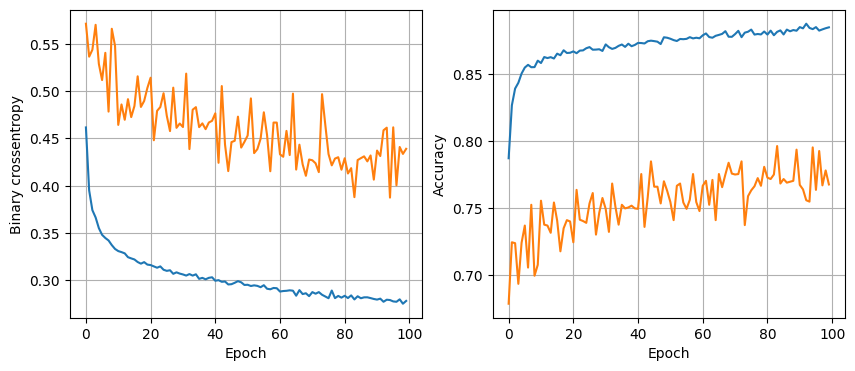

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8811 - loss: 0.2961
nodes 64, dropout 0.2, lr 0.001, batch size 128


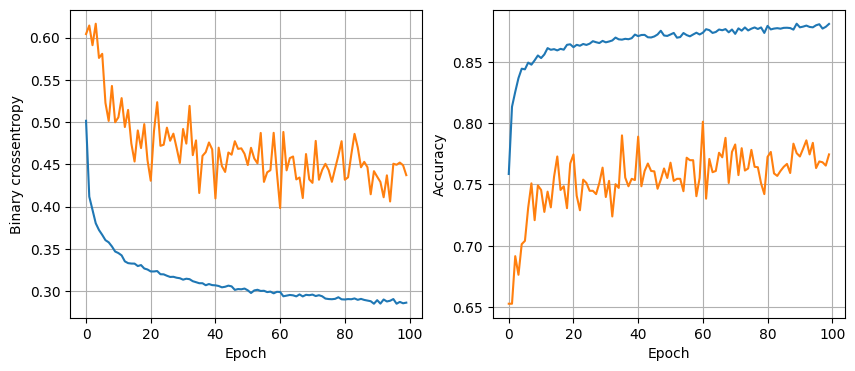

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8742 - loss: 0.2963


In [21]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16,32,64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"nodes {num_nodes}, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = train_model(X_train,y_train,num_nodes,dropout_prob,lr,batch_size,epochs)
                plot_history(history)
                val_loss = model.evaluate(X_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [36]:
valid_loss, valid_accuracy = least_loss_model.evaluate(X_valid, y_valid, verbose=0)
test_loss, test_accuracy = least_loss_model.evaluate(X_test, y_test, verbose=0)
print(f"(Validation data) loss: {valid_loss}, accuracy: {valid_accuracy}")
print(f"(Test data) loss: {test_loss}, accuracy: {test_accuracy}")

y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(y_pred)
print(classification_report(y_test,y_pred))

(Validation data) loss: 0.29447442293167114, accuracy: 0.8811777234077454
(Test data) loss: 0.3041495680809021, accuracy: 0.874605655670166
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0 1 0 ... 1 1 0]
              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1319
           1       0.88      0.94      0.91      2485

    accuracy                           0.87      3804
   macro avg       0.87      0.84      0.86      3804
weighted avg       0.87      0.87      0.87      3804



C:\Users\Sama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


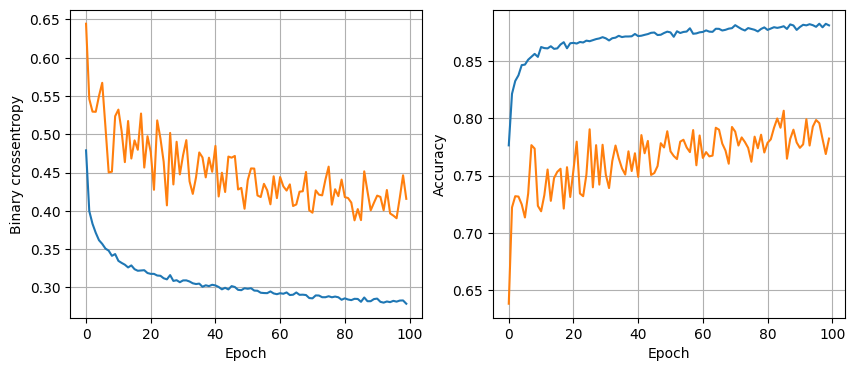

(Validation data) loss: 0.30134955048561096, accuracy: 0.8782860040664673
(Test data) loss: 0.30564549565315247, accuracy: 0.8767087459564209
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1319
           1       0.88      0.94      0.91      2485

    accuracy                           0.88      3804
   macro avg       0.87      0.85      0.86      3804
weighted avg       0.88      0.88      0.87      3804



In [34]:
new_model, new_history = train_model(X_train,y_train,64,0.2,0.001,64,100)
plot_history(new_history)
valid_loss, valid_accuracy = new_model.evaluate(X_valid, y_valid, verbose=0)
test_loss, test_accuracy = new_model.evaluate(X_test, y_test, verbose=0)
print(f"(Validation data) loss: {valid_loss}, accuracy: {valid_accuracy}")
print(f"(Test data) loss: {test_loss}, accuracy: {test_accuracy}")

y_pred = new_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test,y_pred))